In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit as fwrf_fit
# from model_src import fwrf_predict as fwrf_predict
from model_src import bdcn_features

from model_fitting import initialize_fitting as initialize_fitting

bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'

fpX = np.float32

In [69]:
subject=1
roi=None

ridge=True
do_pca=True
min_pct_var=95
max_pc_to_retain=400
map_ind=-1
mult_patch_by_prf=True
n_prf_sd_out = 2

shuffle_images=False
random_images=False
random_voxel_data=False

sample_batch_size=100
voxel_batch_size=100
zscore_features=True

up_to_sess=1
debug=True
shuff_rnd_seed=0

fitting_type='bdcn'

do_fitting=1
do_val=1

date_str=None


In [3]:
print('do_pca=%s'%do_pca)
print('ridge=%s'%ridge)
print('min_pct_var=%s'%min_pct_var)
print('max_pc_to_retain=%s'%max_pc_to_retain)
print('map_ind=%s'%map_ind)
print('n_prf_sd_out=%s'%n_prf_sd_out)
print('mult_patch_by_prf=%s'%mult_patch_by_prf)

device = initialize_fitting.init_cuda()
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
model_name = initialize_fitting.get_bdcn_model_name(do_pca, map_ind)

if do_fitting==False and date_str is None:
    raise ValueError('if you want to start midway through the process (--do_fitting=False), then specify the date when training result was saved (--date_str).')

if do_fitting==False and do_pca==True:
    raise ValueError('Cannot start midway through the process (--do_fitting=False) when doing pca, because the pca weight matrix is not saved in between trn/val.')

if do_fitting==True and date_str is not None:
    raise ValueError('if you want to do fitting from scratch (--do_fitting=True), specify --date_str=None (rather than entering a date)')

output_dir, fn2save = initialize_fitting.get_save_path(root_dir, subject, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)

def save_all():
    print('\nSaving to %s\n'%fn2save)
    torch.save({
    'aperture': aperture,
    'aperture_rf_range': aperture_rf_range,
    'models': models,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': brain_nii_shape,
    'image_order': image_order,
    'voxel_index': voxel_index,
    'voxel_roi': voxel_roi,
    'voxel_ncsnr': voxel_ncsnr, 
    'best_params': best_params,
    'pc': pc2save,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'best_losses': best_losses,
    'val_cc': val_cc,
    'val_r2': val_r2,     
    'zscore_features': zscore_features,        
    'n_prf_sd_out': n_prf_sd_out,
    'mult_patch_by_prf': mult_patch_by_prf,
    'ridge': ridge,
    'do_pca': do_pca,
    'debug': debug,
    'up_to_sess': up_to_sess,
    'shuff_rnd_seed': shuff_rnd_seed
    }, fn2save, pickle_protocol=4)





do_pca=True
ridge=True
min_pct_var=95
max_pc_to_retain=400
map_ind=-1
n_prf_sd_out=2
mult_patch_by_prf=True
#device: 1
device#: 0
device name: GeForce GTX 1080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
Time Stamp: Aug-30-2021_1453_59

Will save final output file to /user_data/mmhender/model_fits/S01/bdcn_pca_fused/Aug-30-2021_1453_59_DEBUG/



In [4]:

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)

# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)


# Set up the pRFs to test
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

            

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
[1, 2, 3, 4, 5]
['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
[1, 2, 3]
['O

In [9]:
# Set up the contour feature extractor
pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_bsds500.pth')
_feature_extractor = bdcn_feature_extractor(pretrained_model_file, device, aperture_rf_range, n_prf_sd_out, \
                                           batch_size=10, map_ind=map_ind, mult_patch_by_prf=mult_patch_by_prf)

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]


/user_data/mmhender/toolboxes/BDCN/bdcn.py:232: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.080)


In [101]:
images = trn_stim_data
voxel_data = trn_voxel_data

prf_params = (0,0,0.04)

_feature_extractor.get_maps(images)

Running BDCN contour feature extraction...
Images array shape is:
(688, 1, 227, 227)
time elapsed = 9.37704


In [102]:
x,y,sigma = prf_params

print('pRF [x,y,sigma]:')
print([x,y,sigma])

n_pix = images.shape[2]

 # Define the RF for this "model" version
prf = torch_utils._to_torch(numpy_utility.make_gaussian_mass(x, y, sigma, n_pix, size=_feature_extractor.aperture_rf_range, \
                          dtype=np.float32)[2], device=_feature_extractor.device)
minval = torch.min(prf)
maxval = torch.max(prf-minval)
prf_scaled = (prf - minval)/maxval
        

pRF [x,y,sigma]:
[0, 0, 0.04]


In [103]:
_feature_extractor.fmaps.shape
fmaps = _feature_extractor.fmaps.detach().cpu().numpy()

(array([ 101.,  198.,  842., 4261., 9684., 8899., 9550., 9735., 6899.,
        1360.]),
 array([-15.43932   , -13.455886  , -11.472451  ,  -9.4890175 ,
         -7.5055833 ,  -5.522149  ,  -3.538715  ,  -1.5552809 ,
          0.42815322,   2.4115872 ,   4.3950214 ], dtype=float32),
 <BarContainer object of 10 artists>)

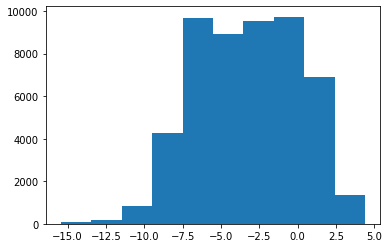

In [104]:
from matplotlib import pyplot as plt
plt.figure();
ii=100
plt.hist(fmaps[ii,0,:,:].ravel())

(array([  6.,   2.,  14.,  55.,  78., 108., 123., 136., 126.,  40.]),
 array([-14.784424  , -12.916598  , -11.048773  ,  -9.180947  ,
         -7.313122  ,  -5.4452963 ,  -3.577471  ,  -1.7096454 ,
          0.15818004,   2.0260055 ,   3.893831  ], dtype=float32),
 <BarContainer object of 10 artists>)

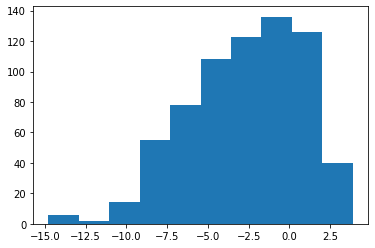

In [24]:
plt.figure();
plt.hist(fmaps[:,0,100,100].ravel())

(array([354.,  52.,  38.,  31.,  30.,  36.,  24.,  30.,  51.,  42.]),
 array([3.7949505e-07, 9.8004282e-02, 1.9600819e-01, 2.9401210e-01,
        3.9201599e-01, 4.9001989e-01, 5.8802378e-01, 6.8602771e-01,
        7.8403163e-01, 8.8203549e-01, 9.8003942e-01], dtype=float32),
 <BarContainer object of 10 artists>)

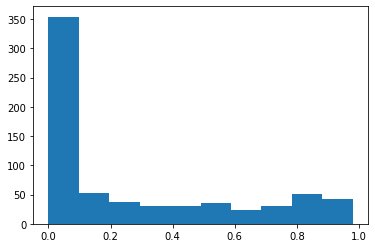

In [74]:
fmaps_sig = torch.sigmoid(_feature_extractor.fmaps).detach().cpu().numpy()

plt.figure();
plt.hist(fmaps_sig[:,0,100,100].ravel())

(array([30083.,  4203.,  2756.,  2151.,  1880.,  1916.,  2015.,  2169.,
         2325.,  2031.]),
 array([1.9714629e-07, 9.8781355e-02, 1.9756250e-01, 2.9634365e-01,
        3.9512482e-01, 4.9390596e-01, 5.9268713e-01, 6.9146830e-01,
        7.9024941e-01, 8.8903058e-01, 9.8781174e-01], dtype=float32),
 <BarContainer object of 10 artists>)

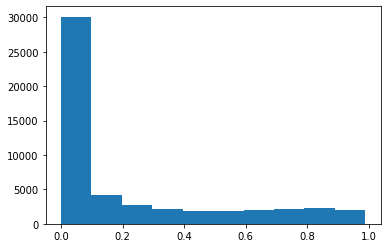

In [75]:
plt.figure();
ii=100
plt.hist(fmaps_sig[ii,0,:,:].ravel())

(array([354.,  52.,  38.,  31.,  30.,  36.,  24.,  30.,  51.,  42.]),
 array([8.6470544e-12, 2.2330948e-06, 4.4661811e-06, 6.6992675e-06,
        8.9323539e-06, 1.1165440e-05, 1.3398526e-05, 1.5631613e-05,
        1.7864699e-05, 2.0097785e-05, 2.2330871e-05], dtype=float32),
 <BarContainer object of 10 artists>)

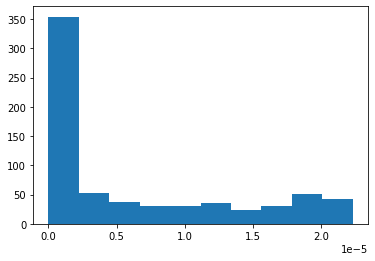

In [28]:
fmaps_sig_prf = (torch.sigmoid(_feature_extractor.fmaps) * prf).detach().cpu().numpy()

plt.figure();
plt.hist(fmaps_sig_prf[:,0,100,100].ravel())

(array([35090.,  5052.,  3944.,  2707.,  1562.,  1280.,   778.,   579.,
          333.,   204.]),
 array([4.1116559e-12, 2.1495737e-06, 4.2991433e-06, 6.4487131e-06,
        8.5982829e-06, 1.0747852e-05, 1.2897422e-05, 1.5046991e-05,
        1.7196560e-05, 1.9346131e-05, 2.1495700e-05], dtype=float32),
 <BarContainer object of 10 artists>)

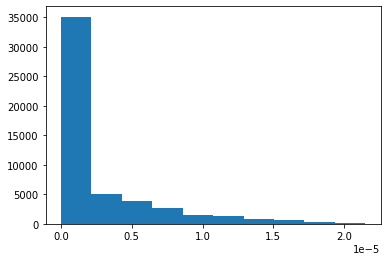

In [29]:
ii=100
plt.figure()
plt.hist(fmaps_sig_prf[ii,0,:,:].ravel())

(array([354.,  52.,  38.,  31.,  30.,  36.,  24.,  30.,  51.,  42.]),
 array([3.6851233e-07, 9.5168009e-02, 1.9033565e-01, 2.8550330e-01,
        3.8067093e-01, 4.7583857e-01, 5.7100624e-01, 6.6617388e-01,
        7.6134151e-01, 8.5650915e-01, 9.5167679e-01], dtype=float32),
 <BarContainer object of 10 artists>)

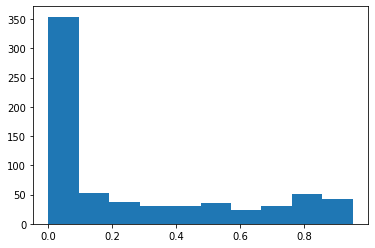

In [79]:
fmaps_sig_prf = (prf_scaled * torch.sigmoid(_feature_extractor.fmaps)).detach().cpu().numpy()

# fmaps_sig_prf = (torch.sigmoid(_feature_extractor.fmaps * prf_scaled)).detach().cpu().numpy()

plt.figure();
plt.hist(fmaps_sig_prf[:,0,100,100].ravel())

In [80]:
torch.sigmoid(prf_scaled)

tensor([[0.5000, 0.5008, 0.5015,  ..., 0.5015, 0.5008, 0.5000],
        [0.5008, 0.5015, 0.5023,  ..., 0.5023, 0.5015, 0.5008],
        [0.5015, 0.5023, 0.5031,  ..., 0.5031, 0.5023, 0.5015],
        ...,
        [0.5015, 0.5023, 0.5031,  ..., 0.5031, 0.5023, 0.5015],
        [0.5008, 0.5015, 0.5023,  ..., 0.5023, 0.5015, 0.5008],
        [0.5000, 0.5008, 0.5015,  ..., 0.5015, 0.5008, 0.5000]],
       device='cuda:0')

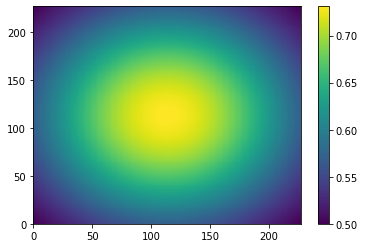

In [85]:
plt.figure();
plt.pcolormesh(torch.sigmoid(prf_scaled).detach().cpu().numpy())
plt.colorbar()

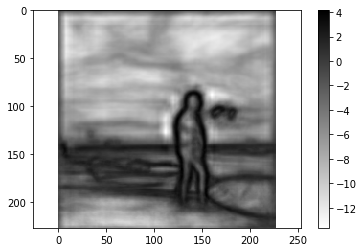

In [105]:
fm = _feature_extractor.fmaps[0,0,:,:].detach().cpu().numpy()
plt.figure()
plt.pcolormesh(fm,cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

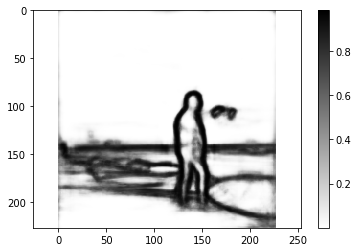

In [106]:
fm_sig = torch.sigmoid(_feature_extractor.fmaps[0,0,:,:]).detach().cpu().numpy()
plt.figure()
plt.pcolormesh(fm_sig,cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

In [107]:
def sigmoid(x):    
    return 1/(1+np.exp(-x))

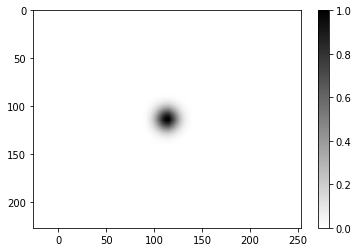

In [108]:
p = prf_scaled.detach().cpu().numpy()

plt.figure()
plt.pcolormesh(p, cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

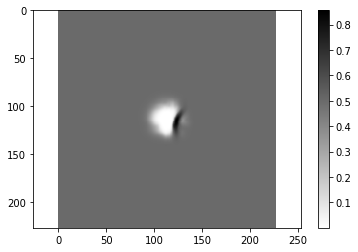

In [109]:
plt.figure()
plt.pcolormesh(sigmoid(p * fm), cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

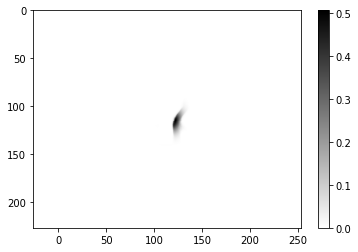

In [110]:
plt.figure()
plt.pcolormesh(p * fm_sig, cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

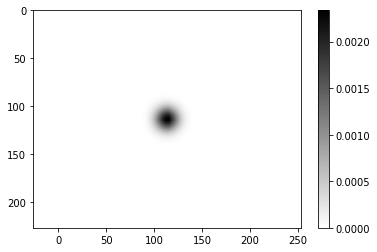

In [111]:
p_unscaled = prf.detach().cpu().numpy()

plt.figure()
plt.pcolormesh(p_unscaled, cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

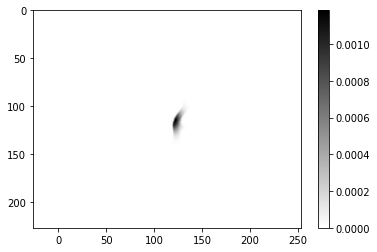

In [112]:
plt.figure()
plt.pcolormesh(p_unscaled * fm_sig, cmap='gray_r')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()

In [41]:
np.sum(p)

0.6903469

In [68]:
import numpy as np
import sys
import torch
import time
import torch.nn as nn
from utils import numpy_utility, torch_utils, texture_utils
bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'
sys.path.append(bdcn_path)
import bdcn

class bdcn_feature_extractor(nn.Module):
    
    def __init__(self, pretrained_model_file, device, aperture_rf_range = 1.1, n_prf_sd_out = 2, \
                 batch_size=10, map_ind = -1, mult_patch_by_prf=True):
        
        super(bdcn_feature_extractor, self).__init__()
        
        self.pretrained_model_file = pretrained_model_file
        self.device = device
        self.load_model_file()
          
        self.aperture_rf_range = aperture_rf_range
        self.n_prf_sd_out = n_prf_sd_out
        self.batch_size = batch_size
        self.map_ind = map_ind
        self.mult_patch_by_prf = mult_patch_by_prf
        self.fmaps = None
             
    def load_model_file(self):
        
        model = bdcn.BDCN()
        model.load_state_dict(torch.load(self.pretrained_model_file))
        model = model.to(self.device)

        self.model = model
        
    def get_maps(self, images):
        
        print('Running BDCN contour feature extraction...')
        print('Images array shape is:')
        print(images.shape)
        t = time.time()
       
        maps_each_scale, names = get_bdcn_maps(self.model, images, self.batch_size, self.map_ind)
        self.fmaps = torch_utils._to_torch(maps_each_scale[0], device=self.device)

        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)        
        
    def clear_maps(self):
        
        print('Clearing BDCN contour features from memory.')
        self.fmaps = None    
    
    def forward(self, images, prf_params):
        
        if self.fmaps is None:
            self.get_maps(images)
        else:
            assert(images.shape[0]==self.fmaps.shape[0])

        x,y,sigma = prf_params

        print('pRF [x,y,sigma]:')
        print([x,y,sigma])

        n_pix = images.shape[2]

         # Define the RF for this "model" version
        prf = torch_utils._to_torch(numpy_utility.make_gaussian_mass(x, y, sigma, n_pix, size=self.aperture_rf_range, \
                                  dtype=np.float32)[2], device=self.device)

        maps_sig = torch.sigmoid(self.fmaps)
        
        if self.mult_patch_by_prf:
            minval = torch.min(prf)
            maxval = torch.max(prf-minval)
            prf_scaled = (prf - minval)/maxval
            # Multiply the feature map by gaussian pRF weights, before cropping
            maps_sig = maps_sig * prf
        
        # Crop the patch +/- n SD away from center
        bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, self.n_prf_sd_out, min_pix=None, verbose=False, force_square=False)
        maps_cropped = maps_sig[:,:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
        
        # return [ntrials x nfeatures]
        # Note this reshaping goes in "C" style order by default
        features = torch.reshape(maps_cropped, [maps_cropped.shape[0], np.prod(maps_cropped.shape[1:])])
        
        return features
    

def get_bdcn_maps(model, images, batch_size=10, map_inds=None):
            
    device = list(model.parameters())[0].device
 
    if map_inds is not None:
        if np.isscalar(map_inds):
            map_inds = [map_inds]
    else:
        map_inds = np.arange(0,11)
        
    n_images = images.shape[0]
    n_batches = int(np.ceil(n_images/batch_size))

    for bb in range(n_batches):

        batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))
        image_batch = images[batch_inds,:,:,:]
        
        out = model(prep_for_bdcn(image_batch, device))    
        out = [oo.detach().cpu().numpy() for oo in out]

        p1_1, p2_1, p3_1, p4_1, p5_1, p1_2, p2_2, p3_2, p4_2, p5_2, fuse = out
        
        # undoing the sums they do at end of forward pass, to get out the raw feature maps at each scale
        # p1_1 = s1
        # p2_1 = s2 + o1
        # p3_1 = s3 + o2 + o1
        # p4_1 = s4 + o3 + o2 + o1
        # p5_1 = s5 + o4 + o3 + o2 + o1

        # p1_2 = s11 + o21 + o31 + o41 + o51
        # p2_2 = s21 + o31 + o41 + o51
        # p3_2 = s31 + o41 + o51
        # p4_2 = s41 + o51
        # p5_2 = s51

        s1_1 = p1_1
        s2_1 = p2_1 - s1_1
        s3_1 = p3_1 - s1_1 - s2_1
        s4_1 = p4_1 - s1_1 - s2_1 - s3_1
        s5_1 = p5_1 - s1_1 - s2_1 - s3_1 - s4_1

        s5_2 = p5_2
        s4_2 = p4_2 - s5_2
        s3_2 = p3_2 - s5_2 - s4_2
        s2_2 = p2_2 - s5_2 - s4_2 - s3_2
        s1_2 = p1_2 - s5_2 - s4_2 - s3_2 - s2_2

        maps_each_scale_this_batch = [s1_1, s2_1, s3_1, s4_1, s5_1, s1_2, s2_2, s3_2, s4_2, s5_2, fuse]

        if bb==0:
            maps_each_scale = [maps_each_scale_this_batch[mi] for mi in map_inds]
        else:
            for ii, mi in enumerate(map_inds):                    
                maps_each_scale[ii] = np.concatenate((maps_each_scale[ii], maps_each_scale_this_batch[mi]), axis=0)
            

    names1 = ['s2d_%d'%(ii+1) for ii in range(5)]
    names2 = ['d2s_%d'%(ii+1) for ii in range(5)]
    names = list(np.concatenate([names1, names2, ['BDCN: fused']]))

    return maps_each_scale, names


def prep_for_bdcn(image_data, device):
    
    if image_data.shape[1]==1:
        image_data = np.tile(image_data, [1,3,1,1])
    else:
        # RGB to BGR
        image_data = image_data[:,-1::,:,:]   
    mean_bgr = np.expand_dims(np.array([104.00699, 116.66877, 122.67892]), [0,2,3])
    dat = image_data * 255 - mean_bgr
    dat = torch.tensor(dat, dtype=torch.float32).to(device)

    return dat

